In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision.datasets import FashionMNIST
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [2]:
# preparing the data
dataset = FashionMNIST(root='data/', download=True, transform=ToTensor())
test_dataset = FashionMNIST(root='data/', train= False, transform=ToTensor())

In [3]:
# preparing validation set by random_split
val_size = 10000
train_size = len(dataset)- val_size
train_ds, val_ds = random_split(dataset,[train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [4]:
#creating dataloader
batch_size =128
train_loader = DataLoader(train_ds, batch_size,shuffle=True, num_workers=4, pin_memory=True,)
val_loader = DataLoader(val_ds,batch_size*2, num_workers=4,pin_memory=True)
test_loader = DataLoader(test_dataset,batch_size*2, num_workers=4, pin_memory=True)

In [5]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item()/ len(preds))

In [6]:
class MnistModel(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, 16)
        self.linear2 = nn.Linear(16,32)
        self.linear3 = nn.Linear(32, out_size)

    def forward(self, xb):
        out = xb.view(xb.size(0), -1)
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)

        return out
     
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


In [7]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [8]:
device = get_default_device()
device

device(type='cuda')

In [9]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [10]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [12]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [13]:
input_size = 784
num_classes = 10

In [14]:
model = MnistModel(input_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=10, bias=True)
)

In [15]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3137359619140625, 'val_acc': 0.11376953125}]

In [16]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.9951, val_acc: 0.5403
Epoch [1], val_loss: 0.8805, val_acc: 0.6009
Epoch [2], val_loss: 0.9939, val_acc: 0.5731
Epoch [3], val_loss: 0.8451, val_acc: 0.6489
Epoch [4], val_loss: 0.7973, val_acc: 0.6540


In [29]:
history += fit(15, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4378, val_acc: 0.8441
Epoch [1], val_loss: 0.4670, val_acc: 0.8290
Epoch [2], val_loss: 0.4820, val_acc: 0.8321
Epoch [3], val_loss: 0.4472, val_acc: 0.8415
Epoch [4], val_loss: 0.4437, val_acc: 0.8423
Epoch [5], val_loss: 0.4463, val_acc: 0.8427
Epoch [6], val_loss: 0.4360, val_acc: 0.8490
Epoch [7], val_loss: 0.4446, val_acc: 0.8439
Epoch [8], val_loss: 0.4516, val_acc: 0.8359
Epoch [9], val_loss: 0.4376, val_acc: 0.8466
Epoch [10], val_loss: 0.4473, val_acc: 0.8430
Epoch [11], val_loss: 0.4402, val_acc: 0.8451
Epoch [12], val_loss: 0.4416, val_acc: 0.8463
Epoch [13], val_loss: 0.4436, val_acc: 0.8464
Epoch [14], val_loss: 0.4417, val_acc: 0.8463


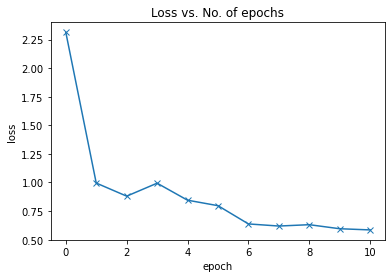

In [18]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [19]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: Pullover , Predicted: Coat


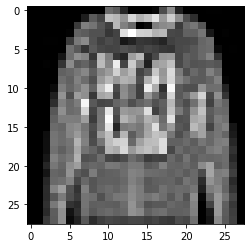

In [20]:
img, label = test_dataset[500]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

In [21]:
evaluate(model, test_loader)

{'val_loss': 0.5906209945678711, 'val_acc': 0.7748047113418579}

In [22]:
# torch.save(model.state_dict(), 'fashion-feed.pth')